In [57]:
%matplotlib inline
## imports

# site
from scipy.ndimage.morphology import binary_erosion
from matplotlib import pyplot as plt
import numpy as np
import rasterio
import flopy

# std
from pathlib import Path
import yaml

In [2]:
def read_array(rasterfile, masked=True,  band=1):
    with rasterio.open(rasterfile) as src:
        return src.read(band, masked=masked)

In [3]:
def read_3d_array(rasterfiles, stack_axis=0, masked=True):
    arrays = []
    for rasterfile in rasterfiles:
        arrays.append(read_array(rasterfile, masked=masked))
    return np.ma.stack(arrays, axis=stack_axis)

In [4]:
## input

# name
name = 'test_dis_icchd_brabant'

# workspace
workspace = Path(r'..\output\dis_icchd')

# grid dimensions
nlay = 19
nrow = 450
ncol = 601
delr = 250.
delc = 250.

# data files
idomainfile = Path(r'..\data\boundary\ibound.tif')
topfile = r'..\data\topbot\RL{ilay:d}.tif'
botfile = r'..\data\topbot\TH{ilay:d}.tif'
startfile = r'..\data\startingheads\HH{ilay:d}.tif'

In [5]:
# read idomain
idomain = read_array(idomainfile).filled(0.)
print(idomain.shape)

(450, 601)


In [6]:
# read tops
topfiles = (Path(topfile.format(ilay=i + 1)) for i in range(nlay))

tops = read_3d_array(topfiles)

# mask bad nodata values
tops = np.ma.masked_where(tops.mask | (tops < -9990.), tops)

# fill masked with zeros
tops = tops.filled(0.)

print(tops.shape)

(19, 450, 601)


In [7]:
# read bots
botfiles = (Path(botfile.format(ilay=i + 1)) for i in range(nlay))

bots = read_3d_array(botfiles)

# mask bad nodata values
bots = np.ma.masked_where(bots.mask | (bots < -9990.), bots)

# fill masked with zeros
bots = bots.filled(0.)

print(bots.shape)

(19, 450, 601)


In [8]:
# convert to top, botm
top = tops[0, :, :]
botm = []
for ilay in range(nlay):
    botm.append(bots[ilay, :, :])
    if (ilay + 1) < nlay:
        botm.append(tops[ilay + 1, :, :])
botm = np.ma.stack(botm)
print(botm.shape)

(37, 450, 601)


In [9]:
# idomain
idomain = np.broadcast_to(idomain, botm.shape)
print(idomain.shape)

(37, 450, 601)


In [42]:
# read start
startfiles = (Path(startfile.format(ilay=i + 1)) for i in range(nlay))
start = np.ma.repeat(read_3d_array(startfiles), 2, axis=0)[:-1, :, :]

# mask values larger than 1000
start = np.ma.masked_where(start.mask | (start > 1e3), start)

# fill masked with zeros
start = start.filled(0.)

print(start.shape)

(37, 450, 601)


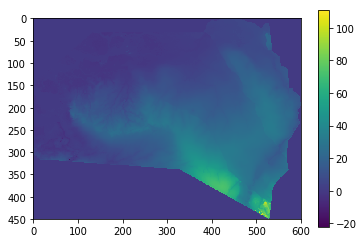

In [43]:
# show start layer 1
plt.imshow(start[0, :, :])
plt.colorbar()

In [44]:
# create workspace directory
workspace.mkdir(exist_ok=True)

In [45]:
# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=name,
    exe_name='mf6', 
    version='mf6',
    sim_ws=str(workspace))

# Create the Flopy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim,
    pname='tdis',
    time_units='DAYS',
    nper=1, 
    perioddata=[(1.0, 1, 1.0)],
    )

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = '{}.nam'.format(name)
gwf = flopy.mf6.ModflowGwf(sim,
    modelname=name, 
   model_nam_file=model_nam_file,
   )

Directory structure already exists for simulation path C:\dev\mf6brabant\mf6brabant\notebooks\..\output\dis_icchd


In [46]:
# initialize the DIS package
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf,
    pname='dis', nlay=(nlay*2 - 1),
    nrow=nrow, ncol=ncol,
    delr=delr, delc=delc,
    top=top, botm=botm,
    idomain=idomain,
    )

In [47]:
# write to package file
dis.write()

In [48]:
# Create the initial conditions package
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname='ic', strt=start)

In [49]:
# write to package file
ic.write()

In [1]:
# get boundary data from idomain and starting heads
isboundary = (idomain[0, :, :] - binary_erosion(idomain[0, :, :])).astype(np.bool)
chd_rec = []
for ilay in range(dis.nlay.get_data()):
    for i, j in np.ndindex(*isboundary.shape):
        if isboundary[i, j]:
            chd_rec.append(((ilay, i, j), start[ilay, i, j]))

NameError: name 'idomain' is not defined

In [82]:
# initialize the CHD package
chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='chd', maxbound=len(chd_rec), 
                                               stress_period_data=chd_rec, save_flows=True)

In [83]:
# write to package file
chd.write()